# Librerias o dependencias para manipular datos, visualizar y herramienta de optimización

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linprog

# leer la hoja de excel

In [23]:
data = pd.read_excel("Datos para Problema de Optimización.xlsx")

# Limpiar y separar las tablas que se van a utilizar en el modelo

In [24]:

#separando las tablas respectivas de la hoja de excel.
demanda_de_cada_ciudad = data.iloc[1:8,1:7]
capacidad_de_produccion_de_cada_fabrica = data.iloc[12:18,1:7]
inventario_inicial = data.iloc[22:25,1:3]
costo_de_produccion = data.iloc[28:34,1:7]
costo_mensual_de_inventario = data.iloc[37:40,1:7]
costo_fijo_de_fabrica_tercerizada = data.iloc[43:47,1:7]
costo_de_transporte  = data.iloc[50:,1:]


# almacenando el nombre de las tablas para posterior uso.
tablas = ["demanda_de_cada_ciudad","capacidad_de_produccion_de_cada_fabrica",
          "inventario_inicial","costo_de_produccion","costo_mensual_de_inventario",
          "costo_fijo_de_fabrica_tercerizada","costo_de_transporte"]

#limpiando los vacios de cada una de las tablas y nombrando correctamente sus columnas.
for tabla in tablas:
    exec(f"{tabla}.columns = {tabla}.iloc[0]")
    exec(f"{tabla} = {tabla}.iloc[1:]")
    exec(f"d_cols = {tabla}.columns")
    exec(f"{tabla} = {tabla}.set_index(d_cols[0])")

# Transformación de los datos 
Pasar las filas a columnas y viceversa de la tabla costo de transporte, añadirle columna de Lima Terceros, luego cambiar el nombre de sus columnas para añadirles si son propias o de terceros, condersarlas en tres columnas que almacenen toda la info de
 origen, destino y costos de transporte; para finalmente unirla con la tabla de costos de produccion y hallar un costo total.


In [25]:

# Pasando las columnas a filas y viceversa, creo una columna nueva llamada Lima Terceros que representa
# la planta de terceros de lima,ordeno las columnas de la tabla en orden alfabetico, renombro las columnas 
# en base a los nombre respectivos de las plantas propias y de terceros, vuelo a transformar las filas en 
# columnas y viceversa, finalizando con un ordenamiento de los nombres y llenando el nombre de una columna
# vacia con el nombre index.
costo_de_transporte_T = costo_de_transporte.T
costo_de_transporte_T["Lima Terceros"] = costo_de_transporte_T["Lima"]
costo_de_transporte_T = costo_de_transporte_T[sorted(costo_de_transporte_T.columns)]
costo_de_transporte_T.columns = costo_de_produccion.sort_index().index
costo_de_transporte_2 = costo_de_transporte_T.T.reset_index()
costo_de_transporte_2.columns = costo_de_transporte_2.columns.fillna("index")

# Transformo la tabla condensando las combinaciones de fuente de produccion y destino de envio con su respectivo 
# coste de transporte,renombro las columnas resultantes a "Desde", "Hacia" y "costo de transporte", realizo una 
# union entre la tabla resultante con la tabla de costo de produccion en base a los puntos de produccion, despues 
# renombro la columna del costo de produccion, creo otra columna llamada costo total de entrega que es igual al costo 
# de transporte mas el costo de produccion y finalmente ordeno la tabla en orden alfabetico en base a los valores de la 
# columna Desde y Hacia.
produccion_optimizada = pd.melt(costo_de_transporte_2,id_vars=["index"],value_vars=costo_de_transporte_2.columns)
produccion_optimizada = produccion_optimizada.rename(columns={"index":"Desde",50:"Hacia","value":"costo de transporte"})
produccion_optimizada = produccion_optimizada.merge(costo_de_produccion.iloc[:,0],right_index=True,left_on="Desde",how="left")
produccion_optimizada = produccion_optimizada.rename(columns={produccion_optimizada.columns[-1]:"costo de produccion"})

produccion_optimizada["costo total de entrega"] = produccion_optimizada["costo de transporte"]+produccion_optimizada["costo de produccion"]
produccion_optimizada = produccion_optimizada.sort_values(["Desde","Hacia"])


# Copio la columna de produccion_optimizada para almacenar 
# costes totales alli sin alterar la otra tabla.
costo_total_de_produccion_sin_contar_almacen = produccion_optimizada.copy()

In [49]:
capacidad_de_produccion_de_cada_fabrica

,enero,febrero,marzo,abril,mayo
NaT,,,,,
Lima – Planta Propia,1080000,1080000,1080000,1200000,1200000
Arequipa – Planta Propia,350000,350000,350000,350000,350000
Lima – Planta de Terceros,200000,200000,200000,200000,200000
Trujillo – Planta de Terceros,80000,80000,80000,80000,80000
Huancayo – Planta de Terceros,10000,10000,10000,170000,170000


In [48]:
demanda_de_cada_ciudad

,enero,febrero,marzo,abril,mayo
NaT,,,,,
Lima,729005,715964,775595,806822,851337
Arequipa,236002,209188,283185,277543,297183
Cusco,178700,198230,197243,257970,360400
Trujillo,244038,226396,290466,301522,311721
Huancayo,139726,117918,117809,142070,147869
Piura,90655,78431,117874,120044,155003


# Definición del modelo a través de las librerias de scipy 

$
\text{ - }{A}_{ub}\text{ representa los coeficientes de las inecuaciones que poseen las 30 variables posibles, }{b}_{ub}
\text{ son los valores a restringir las inecuaciones que representan la máxima capacidad de producción por ciudad.}
$

$
\text{ - }{A}_{eq}\text{ representa los coeficientes de las ecuaciones que poseen las 30 variables posibles, }{b}_{eq}
\text{ son los valores a restringir las ecuaciones que representan la máxima capacidad de producción por ciudad.}
$

$
\text{ - En la funcion objetivo el vector C representa el costo de envio mas el costo de producción de cada posible}
\text{combinacion de planta y destino la denominacion en este caso para cada uno de ellos es }{c}_{ij}\text{.}
$

$
A_{ub},b_{ub}\begin{equation}
\left\{ 
  \begin{aligned}
    \sum_{k=1}^{6}{x}_{11k}\leqslant 1080000,\sum_{k=1}^{6}{x}_{12k}\leqslant 350000,\sum_{k=1}^{6}{x}_{13k}\leqslant 200000,\sum_{k=1}^{6}{x}_{14k}\leqslant 80000,\sum_{k=1}^{6}{x}_{15k}\leqslant 10000,\\
    \sum_{k=1}^{6}{x}_{21k}\leqslant 1080000,\sum_{k=1}^{6}{x}_{22k}\leqslant 350000,\sum_{k=1}^{6}{x}_{23k}\leqslant 200000,\sum_{k=1}^{6}{x}_{24k}\leqslant 80000,\sum_{k=1}^{6}{x}_{25k}\leqslant 10000,\\
    \sum_{k=1}^{6}{x}_{31k}\leqslant 1080000,\sum_{k=1}^{6}{x}_{32k}\leqslant 350000,\sum_{k=1}^{6}{x}_{33k}\leqslant 200000,\sum_{k=1}^{6}{x}_{34k}\leqslant 80000,\sum_{k=1}^{6}{x}_{35k}\leqslant 10000,\\
    \sum_{k=1}^{6}{x}_{41k}\leqslant 1200000,\sum_{k=1}^{6}{x}_{42k}\leqslant 350000,\sum_{k=1}^{6}{x}_{43k}\leqslant 200000,\sum_{k=1}^{6}{x}_{44k}\leqslant 80000,\sum_{k=1}^{6}{x}_{45k}\leqslant 170000,\\
    \sum_{k=1}^{6}{x}_{51k}\leqslant 1200000,\sum_{k=1}^{6}{x}_{52k}\leqslant 350000,\sum_{k=1}^{6}{x}_{53k}\leqslant 200000,\sum_{k=1}^{6}{x}_{54k}\leqslant 80000,\sum_{k=1}^{6}{x}_{55k}\leqslant 170000,\\
    \forall{x}_{ijk} \geqslant 0
  \end{aligned}
  \right.
\end{equation}
$
$
A_{eq},b_{eq}\begin{equation}
\left\{ 
  \begin{aligned}
    \sum_{j=1}^{5}{x}_{1j1} = 729005,\sum_{j=1}^{5}{x}_{1j2} = 236002,\sum_{j=1}^{5}{x}_{1j3} = 178700,\sum_{j=1}^{5}{x}_{1j4} = 244038,\sum_{j=1}^{5}{x}_{1j5} = 139726,\sum_{j=1}^{5}{x}_{1j6}=90655,\\
    \sum_{j=1}^{5}{x}_{2j1} = 715964,\sum_{j=1}^{5}{x}_{2j2} = 209188,\sum_{j=1}^{5}{x}_{2j3} = 198230,\sum_{j=1}^{5}{x}_{2j4} = 226396,\sum_{j=1}^{5}{x}_{2j5} = 117918,\sum_{j=1}^{5}{x}_{2j6}=78431,\\
    \sum_{j=1}^{5}{x}_{3j1} = 775595,\sum_{j=1}^{5}{x}_{3j2} = 283185,\sum_{j=1}^{5}{x}_{3j3} = 197243,\sum_{j=1}^{5}{x}_{3j4} = 290466,\sum_{j=1}^{5}{x}_{3j5} = 117809,\sum_{j=1}^{5}{x}_{3j6}=117874,\\
    \sum_{j=1}^{5}{x}_{4j1} = 806822,\sum_{j=1}^{5}{x}_{4j2} = 277543,\sum_{j=1}^{5}{x}_{4j3} = 257970,\sum_{j=1}^{5}{x}_{4j4} = 301522,\sum_{j=1}^{5}{x}_{4j5} = 142970,\sum_{j=1}^{5}{x}_{4j6}=120044,\\
    \sum_{j=1}^{5}{x}_{5j1} = 851337,\sum_{j=1}^{5}{x}_{5j2} = 297183,\sum_{j=1}^{5}{x}_{5j3} = 360400,\sum_{j=1}^{5}{x}_{5j4} = 311721,\sum_{j=1}^{5}{x}_{5j5} = 147869,\sum_{j=1}^{5}{x}_{5j6}=155003,\\
    \forall{x}_{ij} \geqslant 0
  \end{aligned}
  \right.
\end{equation}
$

$
\text{Función Objetivo = } 
  \begin{aligned}
     \text{min ( }\sum_{i=1}^{5}\sum_{j=1}^{5}\sum_{k=1}^{6}{x}_{ijk}\times{c}_{ijk}\text{ )}
  \end{aligned}
$


# Añadiendo la interacción del almacén
- Diseño vectores que representen el almacén inicial y almacén final planiado.

In [26]:
# Cambio nombre de las columnas para poder manipularlas comodamente.
demanda_de_cada_ciudad.columns = ["enero","febrero","marzo","abril","mayo"]
capacidad_de_produccion_de_cada_fabrica.columns = ["enero","febrero","marzo","abril","mayo"]

In [27]:
"""
    Configuracion del almacen retorna el almacen inicial, almacen final y 
    demanda de cada ciudad de descontando inventario.
"""
def configuracion_de_almacenes(opcion,df):
    
    # Creacion de las tablas de almacen inicial y final poseen como indices
    # los indices de la demanda de cada ciudad.
    almacen_inicial = pd.DataFrame(index=df.index)
    almacen_final = pd.DataFrame(index=df.index)
    
    # Ingreso de datos del almacen inicial en Enero el cual nos dan de dato
    # el primer valor representa el almacen en Lima y el segundo en Arequipa
    # el resto van de relleno para poder operar entre tablas.
    almacen_inicial["enero"] = np.array([40000,60000,0,0,0,0])
    
    # Primera distribucion del almacen final, el cual tiene como diferencia
    # que se usa al maximo la capacidad de produccion en los meses en 
    # que la demanda es mayor a esta.
    if opcion == "A":
        almacen_final["enero"] = np.array([0,0,0,0,0,0])
        almacen_final["febrero"] = np.array([40000,52172,0,0,0,0])
        almacen_final["marzo"] = np.array([10000,20000,0,0,0,0])
        almacen_final["abril"] = np.array([40000,83513,0,0,0,0])
        almacen_final["mayo"] = np.array([0,0,0,0,0,0])
    
    # En la segunda opcion se usa el almacen final, de tal forma que la produccion 
    # nunca alcance su maxima capacidad lo cual modifica ligeramente las rutas con 
    # las que se distribuira la produccion.
    elif opcion == "B":        
        almacen_final["enero"] = np.array([0,0,0,0,0,0])
        almacen_final["febrero"] = np.array([4e+4,6e+4,0,0,0,0])
        almacen_final["marzo"] = np.array([1e+4,2e+4,0,0,0,0])
        almacen_final["abril"] = np.array([4e+4,8.4e+4,0,0,0,0])
        almacen_final["mayo"] = np.array([0,0,0,0,0,0])

    elif opcion == "C":
        almacen_final["enero"] = np.array([7e+4,4e+4,0,0,0,0])
        almacen_final["febrero"] = np.array([3+4,18.5e+4,0,0,0,0])
        almacen_final["marzo"] = np.array([1e+4,2e+4,0,0,0,0])
        almacen_final["abril"] = np.array([4e+4,8.4e+4,0,0,0,0])
        almacen_final["mayo"] = np.array([0,0,0,0,0,0])


    # EL almacen inicial es igual al almacen final del mes anterior.
    almacen_inicial["febrero"] = almacen_final["enero"]
    almacen_inicial["marzo"] = almacen_final["febrero"]
    almacen_inicial["abril"] = almacen_final["marzo"]
    almacen_inicial["mayo"] = almacen_final["abril"]
    
    # Copio la tabla para no alterar la tabla origen.
    demanda_de_cada_ciudad_contando_inventario = df.copy()

    # Adhiero y sustraigo el almacen inicial y final a la tabla copiada.
    demanda_de_cada_ciudad_contando_inventario = demanda_de_cada_ciudad_contando_inventario - almacen_inicial
    demanda_de_cada_ciudad_contando_inventario = demanda_de_cada_ciudad_contando_inventario + almacen_final
    
    return almacen_inicial,almacen_final,demanda_de_cada_ciudad_contando_inventario

In [28]:
# Ejecutando la configuracion de almacenes en la tabla demanda de cada ciudad.
almacen_inicial,almacen_final,demanda_de_cada_ciudad_contando_inventario = configuracion_de_almacenes(opcion="C",df=demanda_de_cada_ciudad)

# Midiendo la capacidad de producción y contratación de terceros
- El objetivo es observar si ambas son capaces de avastecer la demanda en base al inventario planeado.
- Esto ocurre cuando todas las diferencias de la producción con la demanda son positivas.

In [29]:
# Observar si la modificacion del almacen despues de ser añadido a la demanda, permite que la capacidad de produccion 
# sea positiva lo cual significa que puede abastecerse en todos los meses.
capacidad_de_produccion_de_cada_fabrica.sum()-demanda_de_cada_ciudad_contando_inventario.sum()

enero      91874.0
febrero    98866.0
marzo      92835.0
abril         29.0
mayo         487.0
dtype: object

In [30]:
q_2 = []
for mes in demanda_de_cada_ciudad.columns:
    res = produccion_optimizada.copy()
    res["mes"] = mes
    q_2.append(res[["Desde","Hacia","mes"]])

q_2 = pd.concat(q_2)

In [31]:
q_3 = q_2.copy()
q_4 = q_2.copy()

for mes in q_2.mes.unique():
    for planta in q_2.Desde.unique():
        q_3[planta+" - "+mes] = 0
        q_3.loc[(q_2.mes==mes)&(q_2.Desde==planta),planta+" - "+mes] = 1
    
    for ciudad in q_2.Hacia.unique():
        q_4[ciudad+" - "+mes] = 0
        q_4.loc[(q_2.mes==mes)&(q_2.Hacia==ciudad),ciudad+" - "+mes] = 1
    


In [32]:
for mes in ["enero","febrero","marzo"]:
    for tercero in q_4.Desde.unique():
        if "Terceros" in tercero and "Lima" not in tercero:
             q_4[mes+" costo de tercerizacion en "+tercero] = 0
             q_4.loc[(q_4.mes==mes)&(q_4.Desde==tercero),mes+" costo de tercerizacion en "+tercero] = 1


In [33]:
A_eq = q_4.iloc[:,3:].T.values
A_ub = q_3.iloc[:,3:].T.values

b_ub = pd.melt(capacidad_de_produccion_de_cada_fabrica.sort_index(),ignore_index=False).value.values
b_eq = pd.melt(demanda_de_cada_ciudad_contando_inventario.sort_index(),ignore_index=False).value.values
b_eq = np.array(b_eq.tolist()+[0]*6)
c = costo_total_de_produccion_sin_contar_almacen.iloc[:,4].to_list()*5

distribucion_optimizada = linprog(c=c,method="simplex",
            A_eq=A_eq,b_eq=b_eq,
            A_ub=A_ub,b_ub=b_ub,
            bounds=(0,None))


In [34]:
distribucion_optimizada.message

'Optimization terminated successfully.'

In [35]:
q_2["resultado"] = distribucion_optimizada.x
produccion_optimizada[q_2.mes.unique()] = q_2.pivot(columns="mes",index=["Desde","Hacia"],values="resultado")[demanda_de_cada_ciudad.columns].values
costo_total_de_produccion_sin_contar_almacen[demanda_de_cada_ciudad.columns] = q_2.pivot(columns="mes",index=["Desde","Hacia"],values="resultado")[demanda_de_cada_ciudad.columns].values
costo_total_de_produccion_sin_contar_almacen["costo total de entrega"] = costo_total_de_produccion_sin_contar_almacen["costo total de entrega"].astype(float)
costo_total_de_produccion_sin_contar_almacen[demanda_de_cada_ciudad.columns] *= np.array([costo_total_de_produccion_sin_contar_almacen["costo total de entrega"].values.tolist()]*5).T

In [36]:
costo_de_tercerizacion_en_uso = produccion_optimizada.loc[produccion_optimizada.Desde.str.endswith("Terceros")].groupby("Desde").sum()
costo_de_tercerizacion_en_uso = (costo_de_tercerizacion_en_uso>0)*1
costo_de_tercerizacion_en_uso = costo_de_tercerizacion_en_uso*costo_fijo_de_fabrica_tercerizada.sort_index().values
costo_de_tercerizacion_en_uso = costo_de_tercerizacion_en_uso.T
costo_de_tercerizacion_en_uso["Lima – Planta Propia"] = 0
costo_de_tercerizacion_en_uso["Arequipa – Planta Propia"] = 0
costo_de_tercerizacion_en_uso = costo_de_tercerizacion_en_uso.T.sort_index()

costo_de_tercerizacion_en_uso

,enero,febrero,marzo,abril,mayo
Desde,,,,,
Arequipa – Planta Propia,0,0,0,0,0
Huancayo – Planta de Terceros,0,0,0,30000,30000
Lima – Planta Propia,0,0,0,0,0
Lima – Planta de Terceros,50000,50000,50000,50000,50000
Trujillo – Planta de Terceros,0,0,0,12000,12000


In [37]:
(costo_total_de_produccion_sin_contar_almacen.groupby("Desde")[demanda_de_cada_ciudad.columns].sum()+costo_de_tercerizacion_en_uso)

,enero,febrero,marzo,abril,mayo
Desde,,,,,
Arequipa – Planta Propia,109019.94,105000.0,113683.05,105253.71,109104.51
Huancayo – Planta de Terceros,0.0,0.0,0.0,99955.1,99549.17
Lima – Planta Propia,400258.74,412977.78,402224.68,459884.46,442231.88
Lima – Planta de Terceros,151502.78,147243.1,147661.77,143986.37,163722.41
Trujillo – Planta de Terceros,0.0,0.0,0.0,43200.0,43200.0


# Proceso de salida
- Creacion de una tabla que agrupe lo siguiente:
   - Inventario Inicial
   - Produccion
   - Envios
   - Inventario Final
- El proceso cubre todos los meses de produccion y puede ser facilmente configurado para observar otras variables de interes como el costo de produccion, costo de envios y costo de almacenamiento.

In [38]:
# Creacion de la tabla  de resultados el cual resume todos los datos 
# importantes en cada mes.
tabla_de_resultados = pd.DataFrame(index=["enero","febrero","marzo","abril","mayo"])

# Sumamos los valores del inventario inicial y final para cada mes.
tabla_de_resultados["inventario inicial"] = almacen_inicial.sum()
tabla_de_resultados["inventario final"] = almacen_final.sum()

# Sumamos los valores de la produccion para cada mes.
tabla_de_resultados["produccion"] = produccion_optimizada.iloc[:,-5:].sum().values

# Sumamos el valor del inventario inicial con la produccion y le 
# restamos el inventario final para calcular los envios.
tabla_de_resultados["envios"] = tabla_de_resultados[["inventario inicial","produccion"]].sum(axis=1)-tabla_de_resultados["inventario final"]

# Ordenamos la disposicion de las columnas y luego cambios de posicion
# las filas con las columnas para obtener la tabla final.
tabla_de_resultados = tabla_de_resultados[["inventario inicial","produccion","envios","inventario final"]]
tabla_de_resultados = tabla_de_resultados.T

tabla_de_resultados

,enero,febrero,marzo,abril,mayo
inventario inicial,100000.0,110000.0,185007.0,30000.0,124000.0
produccion,1628126.0,1621134.0,1627165.0,1999971.0,1999513.0
envios,1618126.0,1546127.0,1782172.0,1905971.0,2123513.0
inventario final,110000.0,185007.0,30000.0,124000.0,0.0


# Costo de almacenamiento

In [39]:
# Creamos una tabla de costos del almacenamiento que cuenten las otras cuatro
# ciudades destino para poder operar con las otras tablas.
cc = np.array([[.08,.08,.08,.08,.08],[.06,.06,.06,.06,.06],
          [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]])

# Multiplicamos la tabla anterior con la de almacen inicial para obtener el coste
# de almacenar determinada cantidad de almacen en cada ciudad durante cada mes.
cc = cc*almacen_inicial

In [40]:
cc

,enero,febrero,marzo,abril,mayo
NaT,,,,,
Lima,3200.0,5600.0,0.56,800.0,3200.0
Arequipa,3600.0,2400.0,11100.00,1200.0,5040.0
Cusco,0.0,0.0,0.00,0.0,0.0
Trujillo,0.0,0.0,0.00,0.0,0.0
Huancayo,0.0,0.0,0.00,0.0,0.0
Piura,0.0,0.0,0.00,0.0,0.0


In [41]:
# Ponemos en orden alfabetico la tabla en base a las ciudades.  
cc = cc.sort_index()

# Visualizar el resultado del proceso

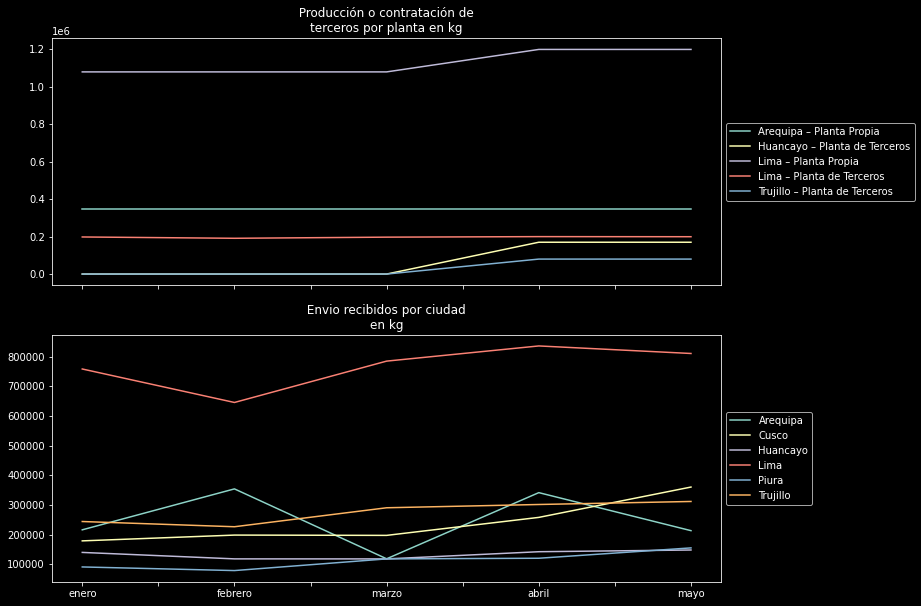

In [42]:
# Modificar el estilo de los ploteos
plt.style.use("dark_background")

fig,(ax,ax_1) = plt.subplots(nrows=2,sharex=True,figsize=(12,10))

# Agrupamos los valores de la distribucion en base a la planta de produccion fuente
# sin contar almacenamiento y sumamos el total de produccion que se genero ahi para 
# luego visualizarlo con una barra horizontal.
df_1 = produccion_optimizada.groupby(["Desde"]).sum()
df_1 = df_1.T
df_1.index = df_1.index.map(lambda x: x.replace(" –","").replace(" ","\n"))
df_1.plot(kind="line",ax=ax,rot=0,title=" Producción o contratación de \nterceros por planta en kg",legend=False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Agrupamos los valores de la distribucion en base a la ciudad destino sin contar
# almacenamiento y sumamos el total de envios recibidos por mes.
df_2 = produccion_optimizada.groupby(["Hacia"]).sum()
df_2 = df_2.T
df_2.index = df_2.index.map(lambda x: x.replace(" –","").replace(" ","\n"))
df_2.plot(kind="line",ax=ax_1,title=" Envio recibidos por ciudad \nen kg",rot=0)
ax_1.legend(loc='center left', bbox_to_anchor=(1, 0.5))